In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt
import pickle
from google.colab import drive
%matplotlib inline
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/cs3244-pg26/data_processed/resale_flat_prices"
df = pd.read_csv(os.path.join(path, "wenjun_data_cleaned.csv"))
X = df.drop(["cpi_psm", "X", "latitude", "longitude"], axis = 1)
y = df["cpi_psm"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [ ]:
X.columns

Index(['flat_type', 'sale_date', 'floor', 'age', 'relative_tenure',
       'floor_area', 'nearest_atm', 'nearest_libraries', 'nearest_hawkers',
       'nearest_stores', 'nearest_post_offices', 'nearest_bus_stops',
       'nearest_pharmacies', 'nearest_primary_schools', 'nearest_parks',
       'nearest_trains'],
      dtype='object')

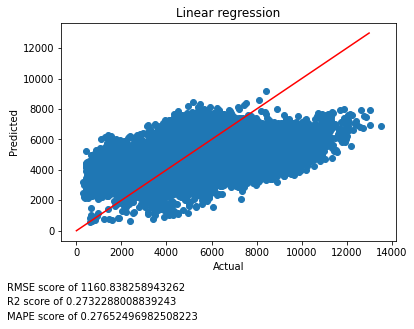

In [ ]:
#Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

#Linear regression score based on prediction
y_pred = model.predict(X_test)
model.score(X_test, y_test)
plt.scatter(y_test,y_pred)
plt.title("Linear regression")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.figtext(0,-0.05,"RMSE score of " + str(mean_squared_error(y_test, y_pred, squared = False)))
plt.figtext(0,-0.1,"R2 score of " + str(r2_score(y_test, y_pred)))
plt.figtext(0,-0.15,"MAPE score of " + str(mean_absolute_percentage_error(y_test, y_pred)))
plt.show()

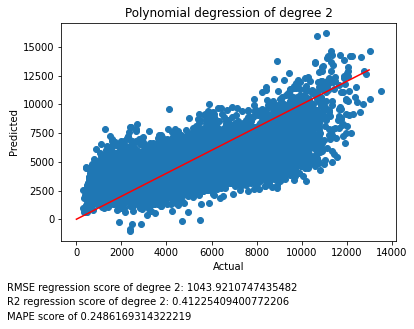

In [ ]:
#Using polynomial regression
i = 2 #Degree of polynomnial
poly = PolynomialFeatures(degree = i)
poly_X = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly.fit(poly_X, y_train)
model = LinearRegression()
model = model.fit(poly_X, y_train)

y_pred = model.predict(poly_X_test)
plt.scatter(y_test,y_pred)
plt.title("Polynomial degression of degree " + str(i))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.figtext(0,-0.05,"RMSE regression score of degree " + str(i) + ": " + str(mean_squared_error(y_test, y_pred, squared = False)))
plt.figtext(0,-0.1,"R2 regression score of degree " + str(i) + ": " + str(r2_score(y_test, y_pred)))
plt.figtext(0,-0.15,"MAPE score of " + str(mean_absolute_percentage_error(y_test, y_pred)))
plt.show()

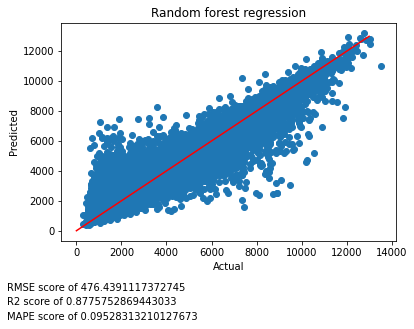

In [ ]:
#Trying out random forest regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50)
model = model.fit(X_train, y_train)

#Predict the testing data
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Random forest regression")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.figtext(0,-0.05,"RMSE score of " + str(mean_squared_error(y_test, y_pred, squared = False)))
plt.figtext(0,-0.1,"R2 score of " + str(r2_score(y_test, y_pred)))
plt.figtext(0,-0.15,"MAPE score of " + str(mean_absolute_percentage_error(y_test, y_pred)))
plt.show()

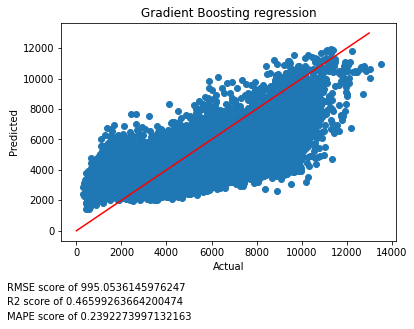

In [ ]:
#Gradient boosting regression
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators = 100)
model = model.fit(X_train, y_train)

# generating predictions for the gradient boosting regressor
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Gradient Boosting regression")
plt.plot(np.linspace(0,13000,100),np.linspace(0,13000,100), "-r")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.figtext(0,-0.05,"RMSE score of " + str(mean_squared_error(y_test, y_pred, squared = False)))
plt.figtext(0,-0.1,"R2 score of " + str(r2_score(y_test, y_pred)))
plt.figtext(0,-0.15,"MAPE score of " + str(mean_absolute_percentage_error(y_test, y_pred)))
plt.show()